In [2]:
!pip install rasterio
!pip install rasterstats
%pip install geopandas matplotlib shapely rasterio numpy pandas sklearn-xarray -q
%pip install git+https://github.com/jgrss/geowombat  -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import rasterstats

In [4]:
# Import GeoWombat
import geowombat as gw
# import plotting
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from geowombat.data import l8_224077_20200518_B2
import pandas as pd
import geopandas as gpd
import os
import rasterio
import matplotlib.pyplot as plt
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
from rasterstats import zonal_stats
import pyproj
from shapely.ops import transform

Importing shapefiles

In [5]:
from google.colab import drive
#conectar este notebook sobre todo el drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [53]:
departments = gpd.read_file('/content/drive/MyDrive/data/INEI_LIMITE_DEPARTAMENTAL/INEI_LIMITE_DEPARTAMENTAL.shp')

In [54]:
departments

,OBJECTID_1,OBJECTID,CCDD,NOMBDEP,CAPITAL,Shape_STAr,Shape_STLe,ORIG_FID,Shape_Leng,Shape_Area,CORREO,CONTACTO,WHATSAPP,geometry
0,1,1.0,01,AMAZONAS,CHACHAPOYAS,3.203006,12.912088,0,12.912088,3.203006,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-77.81399 -2.99278, -77.81483 -2.995..."
1,2,2.0,02,ANCASH,HUARAZ,2.954592,11.780424,1,11.780424,2.954592,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-77.64697 -8.05086, -77.64689 -8.051..."
2,3,3.0,03,APURIMAC,ABANCAY,1.765933,7.730154,2,7.730154,1.765933,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-73.74655 -13.17442, -73.74570 -13.1..."
3,4,4.0,04,AREQUIPA,AREQUIPA,5.330203,17.405040,3,17.405040,5.330203,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-71.98109 -14.64062, -71.98093 -14.6..."
4,5,5.0,05,AYACUCHO,AYACUCHO,3.643705,17.127166,4,17.127166,3.643705,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-74.34843 -12.17503, -74.35000 -12.1..."
5,6,6.0,06,CAJAMARCA,CAJAMARCA,2.684527,12.397424,5,12.397424,2.684527,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-78.22182 -7.76346, -78.22233 -7.763..."
6,7,7.0,07,CALLAO,CALLAO,0.011738,1.111221,6,1.111221,0.011738,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-77.13504 -11.81820, -77.13484 -11.8..."
7,8,8.0,08,CUSCO,CUSCO,6.000331,21.794434,7,21.794434,6.000331,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-72.97280 -11.25189, -72.97134 -11.2..."
8,9,9.0,09,HUANCAVELICA,HUANCAVELICA,1.839851,9.561245,8,9.561245,1.839851,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-74.57118 -11.98710, -74.57095 -11.9..."
9,10,10.0,10,HUANUCO,HUANUCO,3.089811,14.589840,9,14.589840,3.089811,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-75.99200 -8.32108, -75.99015 -8.321..."


EPSG to esri 54009

In [8]:
transformer = pyproj.Transformer.from_crs('epsg:4326', 'esri:54009', always_xy=True)

# Define a function to apply the transformation
def apply_transform(geom):
    return transform(transformer.transform, geom)

# Apply the transformation to the geometries
departments['geometry'] = departments['geometry'].apply(apply_transform)

In [9]:
tif_files = ['/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C10/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C10.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C11/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C11.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C12/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C12.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R11_C11/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R11_C11.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R11_C12/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R11_C12.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R12_C11/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R12_C11.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R12_C12/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R12_C12.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R9_C10/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R9_C10.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R9_C11/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R9_C11.tif',
             '/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R9_C12/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R9_C12.tif']

In [9]:
#tif_files = ['/content/drive/MyDrive/data/rasters/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C10/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R10_C10.tif']

In [11]:
dep_stats = []

In [10]:
#recorrer las imagenes
for raster_path in tif_files:
    stats = zonal_stats(departments, raster_path, stats="count sum", categorical=True, all_touched=True)
    stats_df = pd.DataFrame(stats)
    df = pd.concat([departments.reset_index(drop=True), stats_df], axis=1)
    dep_stats.append(df)

NameError: name 'dep_stats' is not defined

In [34]:
dep_stats

[    OBJECTID_1  OBJECTID CCDD        NOMBDEP           CAPITAL  Shape_STAr  \
 0            1       1.0   01       AMAZONAS       CHACHAPOYAS    3.203006   
 1            2       2.0   02         ANCASH            HUARAZ    2.954592   
 2            3       3.0   03       APURIMAC           ABANCAY    1.765933   
 3            4       4.0   04       AREQUIPA          AREQUIPA    5.330203   
 4            5       5.0   05       AYACUCHO          AYACUCHO    3.643705   
 5            6       6.0   06      CAJAMARCA         CAJAMARCA    2.684527   
 6            7       7.0   07         CALLAO            CALLAO    0.011738   
 7            8       8.0   08          CUSCO             CUSCO    6.000331   
 8            9       9.0   09   HUANCAVELICA      HUANCAVELICA    1.839851   
 9           10      10.0   10        HUANUCO           HUANUCO    3.089811   
 10          11      11.0   11            ICA               ICA    1.767025   
 11          12      12.0   12          JUNIN       

In [24]:
# prompt: listar columnas de dep_stats

for df in dep_stats:
    print(df.columns.tolist())


['OBJECTID_1', 'OBJECTID', 'CCDD', 'NOMBDEP', 'CAPITAL', 'Shape_STAr', 'Shape_STLe', 'ORIG_FID', 'Shape_Leng', 'Shape_Area', 'CORREO', 'CONTACTO', 'WHATSAPP', 'geometry', 'count', 'sum', 0, 1, 2, 3, 4, 5, 11, 12, 13, 14, 21, 22, 23, 24]


In [31]:
#unir en un solo dataframe
baseFinal = pd.concat(dep_stats, ignore_index=True)
baseFinal.fillna(0, inplace=True)

OBJECTID_1     0
OBJECTID       0
CCDD           0
NOMBDEP        0
CAPITAL        0
Shape_STAr     0
Shape_STLe     0
ORIG_FID       0
Shape_Leng     0
Shape_Area     0
CORREO         0
CONTACTO       0
WHATSAPP       0
geometry       0
count          0
sum           22
0             22
1             23
2             23
3             23
4             23
5             23
11            23
12            23
13            23
14            23
21            23
22            24
23            23
24            24
dtype: int64


In [29]:
pixel_area = 100
baseFinal['polygon_area'] = baseFinal['geometry'].apply(lambda x: x.area)
for category in range(1, 16):
    category_str = str(category)
    if category_str not in baseFinal.columns:
        baseFinal[category_str] = 0
        baseFinal[f'MSZ_{category}_coverage'] = (baseFinal[category_str] * pixel_area / baseFinal['polygon_area']) * 100

,OBJECTID_1,OBJECTID,CCDD,NOMBDEP,CAPITAL,Shape_STAr,Shape_STLe,ORIG_FID,Shape_Leng,Shape_Area,...,MSZ_6_coverage,MSZ_7_coverage,MSZ_8_coverage,MSZ_9_coverage,MSZ_10_coverage,MSZ_11_coverage,MSZ_12_coverage,MSZ_13_coverage,MSZ_14_coverage,MSZ_15_coverage
0,1,1.0,01,AMAZONAS,CHACHAPOYAS,3.203006,12.912088,0,12.912088,3.203006,...,0,0,0,0,0,0,0,0,0,0
1,2,2.0,02,ANCASH,HUARAZ,2.954592,11.780424,1,11.780424,2.954592,...,0,0,0,0,0,0,0,0,0,0
2,3,3.0,03,APURIMAC,ABANCAY,1.765933,7.730154,2,7.730154,1.765933,...,0,0,0,0,0,0,0,0,0,0
3,4,4.0,04,AREQUIPA,AREQUIPA,5.330203,17.405040,3,17.405040,5.330203,...,0,0,0,0,0,0,0,0,0,0
4,5,5.0,05,AYACUCHO,AYACUCHO,3.643705,17.127166,4,17.127166,3.643705,...,0,0,0,0,0,0,0,0,0,0
5,6,6.0,06,CAJAMARCA,CAJAMARCA,2.684527,12.397424,5,12.397424,2.684527,...,0,0,0,0,0,0,0,0,0,0
6,7,7.0,07,CALLAO,CALLAO,0.011738,1.111221,6,1.111221,0.011738,...,0,0,0,0,0,0,0,0,0,0
7,8,8.0,08,CUSCO,CUSCO,6.000331,21.794434,7,21.794434,6.000331,...,0,0,0,0,0,0,0,0,0,0
8,9,9.0,09,HUANCAVELICA,HUANCAVELICA,1.839851,9.561245,8,9.561245,1.839851,...,0,0,0,0,0,0,0,0,0,0
9,10,10.0,10,HUANUCO,HUANUCO,3.089811,14.589840,9,14.589840,3.089811,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Lista de las columnas de cobertura que quieres graficar
coverage_columns = [col for col in baseFinal.columns if 'MSZ_' in col and '_coverage' in col]

# Crear un mapa coroplético para cada categoría de MSZ
for coverage_column in coverage_columns:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    baseFinal.plot(column=coverage_column, ax=ax, legend=True,
                  legend_kwds={'label': f"Coverage of {coverage_column}",
                               'orientation': "horizontal"})
    ax.set_title(f"Map of {coverage_column}")
    plt.show()

TypeError: argument of type 'int' is not iterable

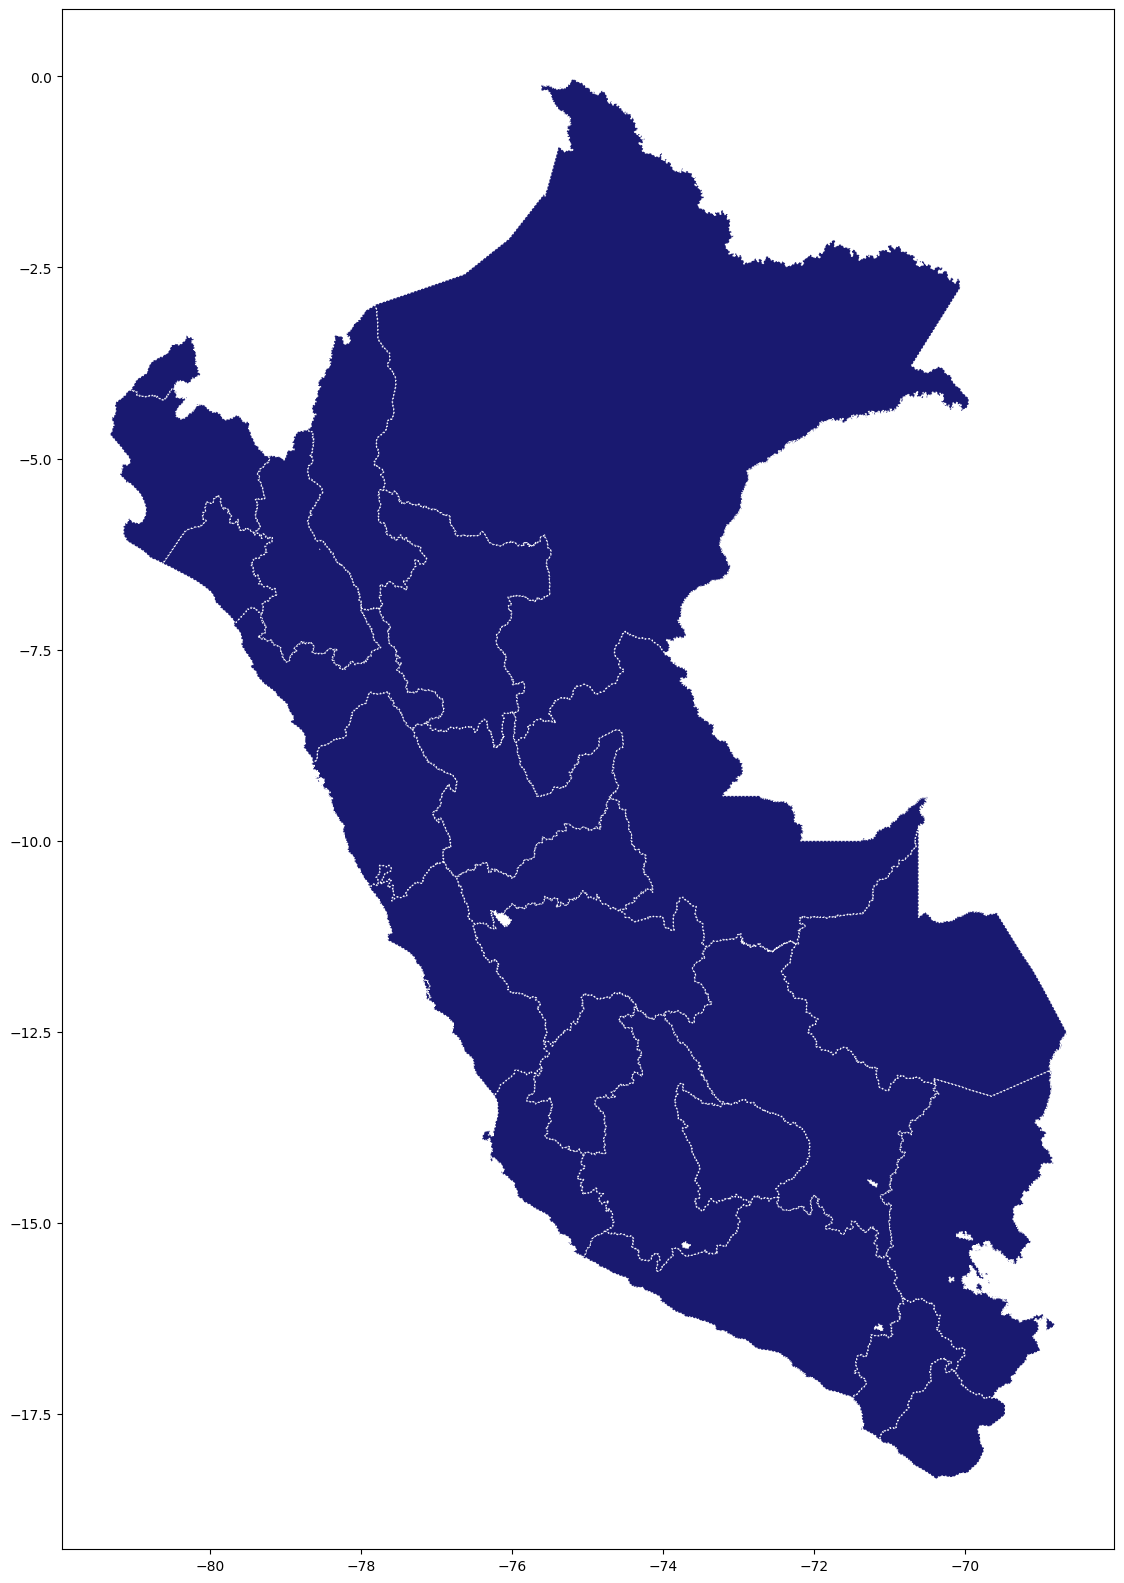

In [60]:
ig, ax = plt.subplots(figsize=(20, 20))

departments.plot(  ax=ax, color='midnightblue', linestyle='dotted',
            edgecolor='white' )
plt.show()

ValueError: aspect must be finite and positive 

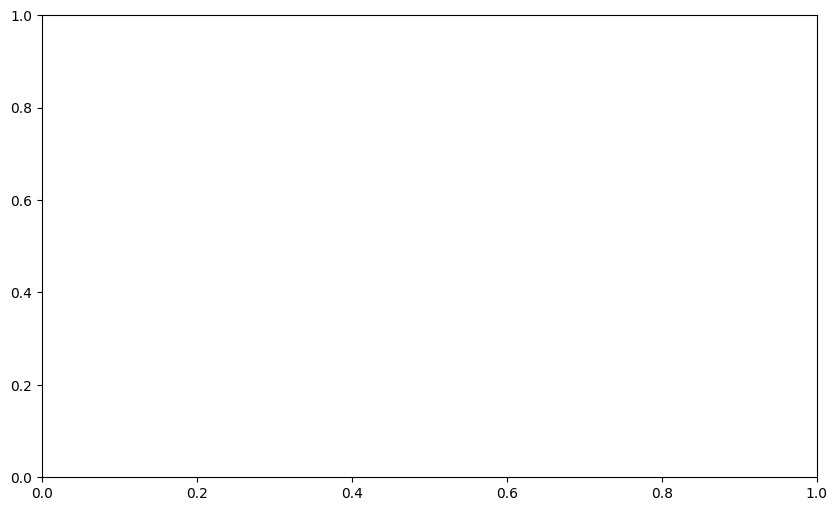

In [61]:
coverage_columns = [col for col in baseFinal.columns.map(str) if '_coverage' in col]
for coverage_column in coverage_columns:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    baseFinal.plot(column=coverage_column, ax=ax, legend=True,
                  legend_kwds={'label': f"Coverage of {coverage_column}",
                               'orientation': "horizontal"})
    ax.set_title(f"Map of {coverage_column}")
    plt.show()